In [ ]:
#Group project

In [7]:
# import packages
library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)                                    # Install data.table
library("data.table")  
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [8]:
train <- read_excel("data/Training_data.xls") %>% mutate(Class = as_factor(UNS))

In [9]:
train

STG,SCG,STR,LPR,PEG,UNS,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low,very_low
0.08,0.08,0.10,0.24,0.90,High,High
0.06,0.06,0.05,0.25,0.33,Low,Low
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High,High
0.50,0.75,0.81,0.61,0.26,Middle,Middle
0.66,0.90,0.76,0.87,0.74,High,High


In [19]:
# explore data
num_obs <- nrow(train)
train %>%
  group_by(Class) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )%>%
arrange(by=desc(percentage))

`summarise()` ungrouping output (override with `.groups` argument)



Class,count,percentage
<fct>,<int>,<dbl>
Middle,88,34.108527
Low,83,32.170543
High,63,24.418605
very_low,24,9.302326


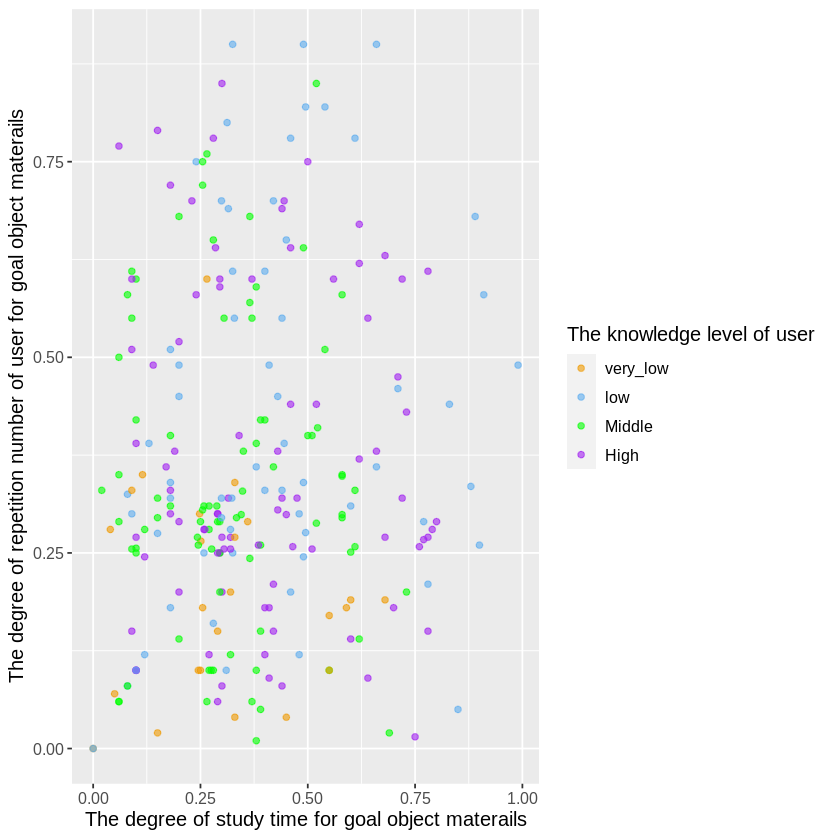

In [22]:
#scatter plot to visualize
perim_concav <- train %>%
  ggplot(aes(x = STG, y = SCG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "The degree of study time for goal object materails", 
       y = "The degree of repetition number of user for goal object materails",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 12))
perim_concav

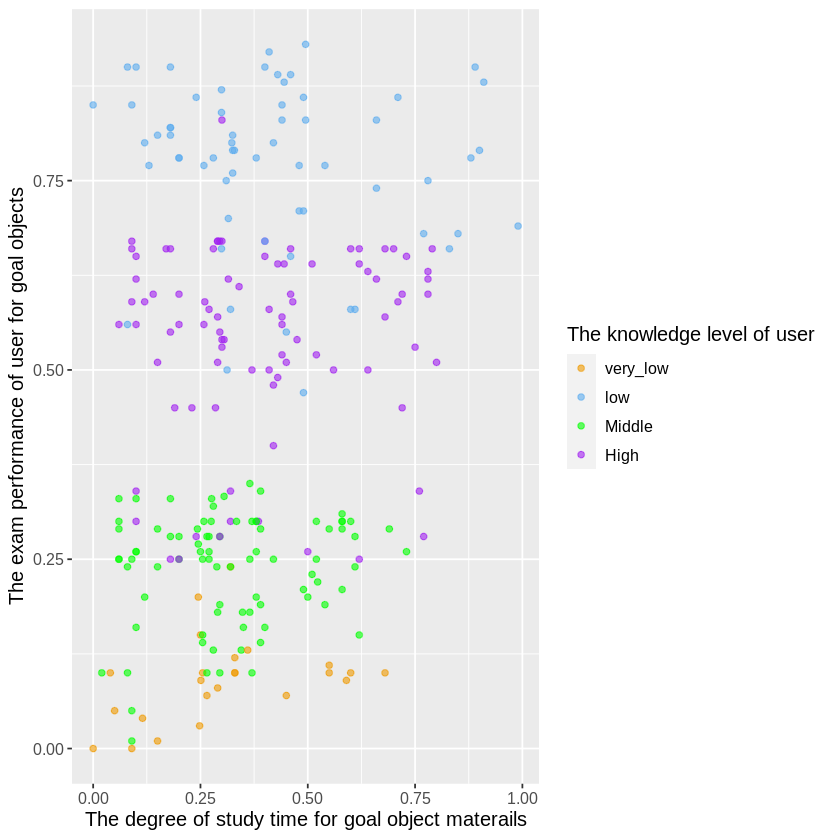

In [27]:
perim_concav_2 <- train %>%
  ggplot(aes(x = STG, y = PEG, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "The degree of study time for goal object materails", 
       y = "The exam performance of user for goal objects",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 12))
perim_concav_2

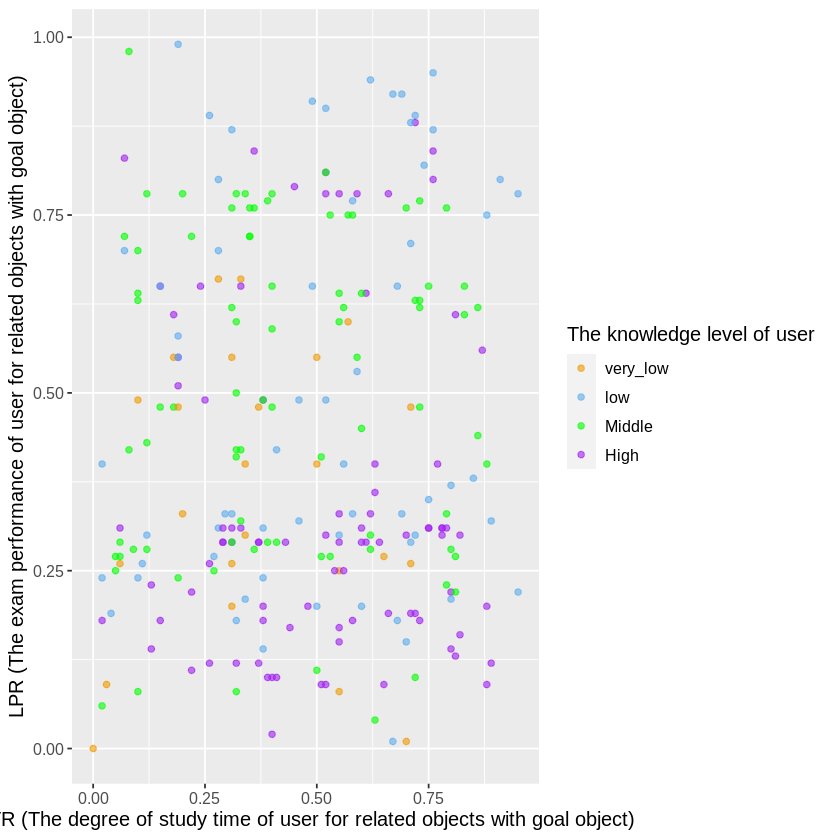

In [26]:
perim_concav_3 <- train %>%
  ggplot(aes( x= STR, y = LPR, color = Class)) +
  geom_point(alpha = 0.6) +
  labs(x = "STR (The degree of study time of user for related objects with goal object)", 
       y = "LPR (The exam performance of user for related objects with goal object)",
       color = "The knowledge level of user") +
  scale_color_manual(labels = c("very_low","low", "Middle","High"), 
                     values = c("orange2", "steelblue2","green","purple")) +
  theme(text = element_text(size = 12))
perim_concav_3

In [28]:
# Set the seed. Don't remove this!
set.seed(9999) 
data_recipe<- recipe(Class ~ STG + SCG + STR + LPR + PEG , data = train) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())
##define the model

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
       set_engine("kknn") %>%
       set_mode("classification")

##workflow
model_workflow <- workflow() %>%
                   add_recipe(data_recipe) %>%
                   add_model(knn_spec)

In [29]:
#train the model using the `fit` function.
model_fit<-fit(model_workflow,data=train)

In [13]:
test <- read_excel("data/test_data.xlsx") %>% mutate(Class = as_factor(UNS))
test

STG,SCG,STR,LPR,PEG,UNS,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low,Very Low
0.05,0.05,0.55,0.60,0.14,Low,Low
0.08,0.18,0.63,0.60,0.85,High,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low,Low
0.66,0.68,0.81,0.57,0.57,Middle,Middle
0.68,0.64,0.79,0.97,0.24,Middle,Middle


In [14]:
knn_fit_all <- model_fit %>%
             fit(data = train)
test_predictions <- predict(knn_fit_all, test)
test_predictions

.pred_class
<fct>
very_low
Low
High
⋮
Middle
Middle
Middle


In [51]:
# get prediction on test
predicted <- test %>% 
  bind_cols(predict(knn_fit_all, test)) %>% 
  bind_cols(predict(knn_fit_all, test, type = "prob"))

# quick check
predicted %>% 
  select(Class, matches(".pred"))

# test_pred <- predict(knn_fit_all, new_data = test) %>%
#   bind_cols(predict(knn_fit_all, test, type = "prob")) %>%
#   bind_cols(test %>% select(UNS))

Class,.pred_class,.pred_very_low,.pred_High,.pred_Low,.pred_Middle
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Very Low,very_low,0.8,0,0.2,0.0
Low,Low,0.0,0,0.8,0.2
High,High,0.0,1,0.0,0.0
⋮,⋮,⋮,⋮,⋮,⋮
Low,Middle,0,0.0,0.2,0.8
Middle,Middle,0,0.4,0.0,0.6
Middle,Middle,0,0.2,0.2,0.6


In [52]:
predict_accuracy <- predicted %>% accuracy(truth = Class, estimate=.pred_class)

ERROR: Error: Problem with `summarise()` input `.estimate`.
[31m✖[39m `truth` and `estimate` levels must be equivalent.
`truth`: Very Low, Low, High, Middle
`estimate`: very_low, High, Low, Middle

[34mℹ[39m Input `.estimate` is `metric_fn(truth = Class, estimate = .pred_class, na_rm = na_rm)`.
